In [1]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)

In [17]:
df = pd.read_csv("../data/processed/all_shots_final-v2.csv", index_col=0)
df.drop(['PLAYER1_NAME'], axis=1, inplace=True)
df.dropna(inplace=True)
print(df.columns)
print(df.shape)

Index(['Shot Distance', 'Season Type', 'Shot Zone Basic_In The Paint (Non-RA)',
       'Shot Zone Basic_Right Corner 3', 'Shot Zone Area_Right Side(R)',
       'Shot Zone Range_8-16 ft.', 'at_home', 'PREVIOUS_OFF_MISSED', 'Age',
       'ASTM', 'ORBM', 'FT%', 'height', 'weight', 'C', 'SG-PG', 'E_DEF_RATING',
       'PCT_AREA', 'DETAILLED_SHOT_TYPE_JUMP SHOT', 'target'],
      dtype='object')
(428835, 20)


In [18]:
# Delete outliers
Q1 = df['Shot Distance'].quantile(0.25)
Q3 = df['Shot Distance'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df = df[(df['Shot Distance'] >= lower_bound) & (df['Shot Distance'] <= upper_bound)]

print(df.shape)

(427956, 20)


## Séparation des données

In [7]:
# prepare data for modeling   
X = df.drop('target', axis = 1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True)

## Standardisation et réduction de dimension

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_scaled['target'] = y_train

# réduction de dimensions
sel_var = VarianceThreshold(0.0001)
X_train_scaled = sel_var.fit_transform(X_train_scaled, y_train)
X_test_scaled = sel_var.transform(X_test_scaled)

# réduction de dimensions
sel_k_best = SelectKBest(f_classif, k = 20)
sel_k_best.fit(X_train, y_train)
X_train_kbst = sel_k_best.transform(X_train)
X_test_kbst = sel_k_best.transform(X_test)

# Affichage des variables sélectionnées
# kbst = pd.DataFrame(sel_k_best.get_support(), index=X_train.columns)
# kbst["score"]=sel_k_best.scores_
# kbst.sort_values("score", ascending=False)

c:\Users\Sarah\anaconda3\envs\nba_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=19. All the features will be returned.
  warnings.warn(


Composantes Principales retenues :  15


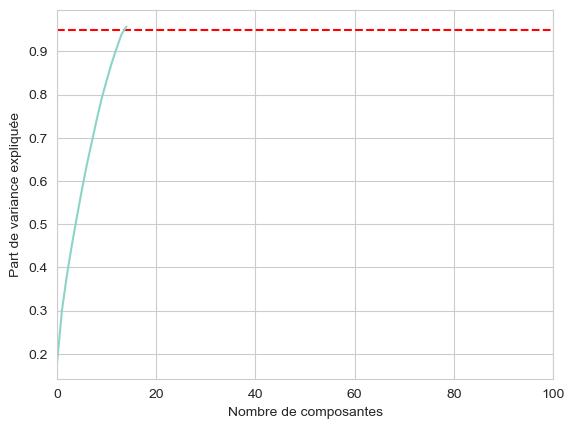

In [6]:
pca = PCA()
pca.fit(X_train_scaled)

pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Composantes Principales retenues : ", pca.n_components_)

plt.figure()
plt.xlim(0,100)
plt.xlabel('Nombre de composantes')
plt.ylabel('Part de variance expliquée')
plt.axhline(y = 0.95, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());

## OverSampling

In [19]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution of the target variable after resampling
print("Before resampling:")
print(y_train.value_counts())
print("\nAfter resampling:")
print(pd.Series(y_train_resampled).value_counts())

Before resampling:
target
1    193652
0    148712
Name: count, dtype: int64

After resampling:
target
1    193652
0    193652
Name: count, dtype: int64


## Arbre de décision

In [10]:
dt_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=5)

dt_clf.fit(X_train_resampled, y_train_resampled)
y_pred = dt_clf.predict(X_test)
print('Train accuracy with DT:', dt_clf.score(X_train_resampled, y_train_resampled))
print('Test accuracy with DT:', dt_clf.score(X_test, y_test))
pd.crosstab(y_test, y_pred, rownames=["Classes réelles"], colnames=["Classes prédites"])

Train accuracy with DT: 0.6783198727614483
Test accuracy with DT: 0.6679362557248341


Classes prédites,0,1
Classes réelles,,
0,25819,11359
1,17063,31351


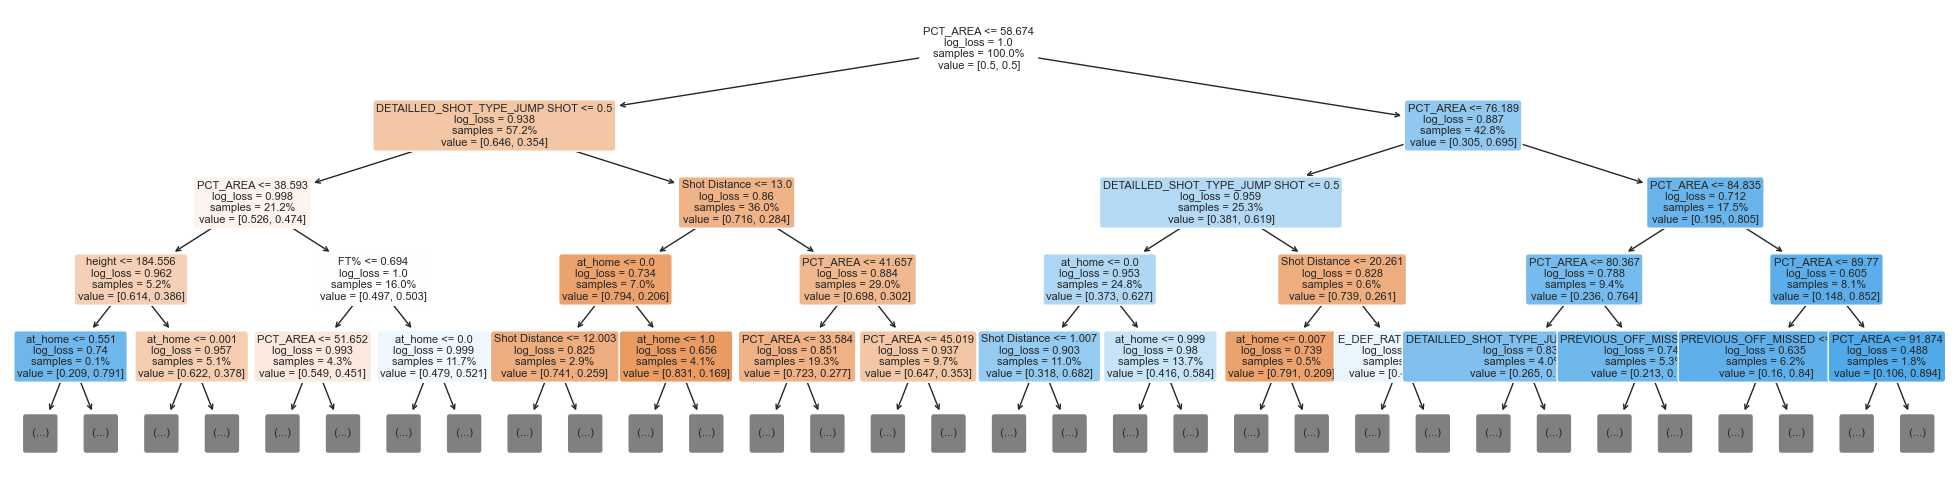

In [11]:
plt.figure(figsize=(25,6))
plot_tree(dt_clf,feature_names=X_train_resampled.columns, filled=True, proportion=True, rounded=True, fontsize=8, max_depth=4)
plt.show()

In [12]:
import optuna

def dtree_objective(trial):
    
    md = trial.suggest_int('max_depth', 2, 64)
    mi = trial.suggest_int('min_samples_split', 2, 32)
    cr = trial.suggest_categorical("criterion", ["entropy", "gini", "log_loss"])
    minleaf = trial.suggest_int('min_samples_leaf', 1, 32)
    
    clf =  DecisionTreeClassifier(max_depth=md, min_samples_leaf=minleaf, criterion=cr, min_samples_split=mi)

    scores = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    
    return scores.mean()
    
dtree_study = optuna.create_study(direction='maximize')
dtree_study.optimize(dtree_objective, n_trials=20)

print("Number of finished trials: ", len(dtree_study.trials))
print("Best trial:")
trial = dtree_study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

c:\Users\Sarah\anaconda3\envs\nba_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-14 10:01:26,406] A new study created in memory with name: no-name-ccb1b83e-3508-4df5-83ee-9159ddac1e26
[I 2024-10-14 10:01:33,855] Trial 0 finished with value: 0.6661925574647556 and parameters: {'max_depth': 53, 'min_samples_split': 31, 'criterion': 'log_loss', 'min_samples_leaf': 19}. Best is trial 0 with value: 0.6661925574647556.
[I 2024-10-14 10:01:41,572] Trial 1 finished with value: 0.6622964064376309 and parameters: {'max_depth': 50, 'min_samples_split': 15, 'criterion': 'entropy', 'min_samples_leaf': 12}. Best is trial 0 with value: 0.6661925574647556.
[I 2024-10-14 10:01:48,923] Trial 2 finished with value: 0.6722833589849483 and parameters: {'max_depth': 62, 'min_samples_split': 15, 'criterion': 'log_loss', 

Number of finished trials:  20
Best trial:
  Value: 0.6842635779904374
  Params: 
    max_depth: 12
    min_samples_split: 3
    criterion: gini
    min_samples_leaf: 24


# Régression Logistique

In [10]:
scaler = StandardScaler()

lr = LogisticRegression(solver='lbfgs', max_iter=5000)

lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
print('Train accuracy:', lr.score(X_train_scaled, y_train))
print('Test accuracy:', lr.score(X_test_scaled, y_test))
pd.crosstab(y_test, y_pred, rownames=["Classes réelles"], colnames=["Classes prédites"])

lr.coef_

Train accuracy: 0.6745863793766833
Test accuracy: 0.6759359660475475


array([[ 1.27678437e-01, -2.40892329e-02,  2.19249876e-02,
        -1.17893353e-04,  1.55035048e-02, -4.77855455e-02,
        -7.74798845e-02,  4.86606322e-02, -6.17571800e-04,
        -2.71527539e-02, -5.79861565e-03,  5.78157620e-02,
         5.35519871e-03,  7.29141033e-03, -1.08241314e-02,
         8.65134194e-03, -4.79187084e-03,  6.80248716e-01,
        -3.48729590e-01]])

In [13]:
pd.DataFrame(lr.coef_[0], X_train.columns).sort_values(0, ascending=False)

,0
PCT_AREA,0.680249
Shot Distance,0.127678
FT%,0.057816
PREVIOUS_OFF_MISSED,0.048661
Shot Zone Basic_In The Paint (Non-RA),0.021925
Shot Zone Area_Right Side(R),0.015504
SG-PG,0.008651
weight,0.007291
height,0.005355
Shot Zone Basic_Right Corner 3,-0.000118


In [14]:
print(df[df.target==1].PCT_AREA.mean())
print(df[df.target==0].PCT_AREA.mean())


62.48583397205905
48.677389810521106


In [99]:
n = X_train.shape[1]

pca = PCA(n_components=2)

scaler = StandardScaler()

pipeline_pca = Pipeline(steps = [('normalization', scaler),
                                 ('pca', pca)])

X_new = pipeline_pca.fit_transform(X_train)

coeff = pca.components_.transpose()

xs = X_new[:, 0]
ys = X_new[:, 1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())


principalDf = pd.DataFrame({'PC1': xs*scalex, 'PC2': ys * scaley})

y_train_pred = pipeline.predict(X_train)
finalDF = pd.concat([principalDf, pd.Series(
    y_train_pred, name='income')], axis=1)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(15)
fig.set_figwidth(15)

ax.set_facecolor('xkcd:salmon')

sns.scatterplot(x='PC1', y='PC2', hue='income', data=finalDF, alpha=0.5, ax=ax)
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0]*1.5, coeff[i, 1]*1.5,
              color='k', alpha=0.5, head_width=0.01, )
    plt.text(coeff[i, 0]*1.5, coeff[i, 1] * 1.5, X_train.columns[i], color='k')

plt.xlim(-0.6, 0.8)
plt.ylim(-0.8, 0.8)

## Random Forest

In [23]:
clf = RandomForestClassifier(n_jobs = -1, criterion='log_loss', max_depth=7)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Train accuracy:', clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))
pd.crosstab(y_test, y_pred, rownames=["Classes réelles"], colnames=["Classes prédites"])

Train accuracy: 0.6801158953910011
Test accuracy: 0.6804598505252603


Classes prédites,0,1
Classes réelles,,
0,22310,15036
1,12370,36051


## KNN Classifier

In [16]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=20)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
print('Train accuracy:', clf.score(X_train_scaled, y_train))
print('Test accuracy:', clf.score(X_test_scaled, y_test))
pd.crosstab(y_test, y_pred, rownames=["Classes réelles"], colnames=["Classes prédites"])

Train accuracy: 0.6999224643510907
Test accuracy: 0.6689286089055231


Classes prédites,0,1
Classes réelles,,
0,23343,14003
1,14392,34029


In [32]:
from sklearn.svm import SVC

clf = SVC(C=0.1)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
print('Train accuracy:', clf.score(X_train_scaled, y_train))
print('Test accuracy:', clf.score(X_test_scaled, y_test))
pd.crosstab(y_test, y_pred, rownames=["Classes réelles"], colnames=["Classes prédites"])

Train accuracy: 0.6756677976377861
Test accuracy: 0.6759359660475475


Classes prédites,0,1
Classes réelles,,
0,20619,16727
1,11067,37354


In [35]:
import joblib
joblib.dump(clf, "trained_svm.save")

['trained_svm.save']

## XGBoost

In [14]:
import xgboost as xgb
train = xgb.DMatrix(data=X_train_resampled, label=y_train_resampled)
test = xgb.DMatrix(data=X_test, label=y_test)

params = {"objective": "binary:logistic"}
clf = xgb.train(params, train)
train_preds = clf.predict(train)
tests_preds = clf.predict(test)
y_pred_train = np.rint(train_preds)
y_pred_test = np.rint(tests_preds)
print('Train accuracy:', accuracy_score(y_train_resampled, y_pred_train ))
print('Test accuracy:', accuracy_score(y_test, y_pred_test ))
pd.crosstab(y_test, y_pred_test, rownames=["Classes réelles"], colnames=["Classes prédites"])

Train accuracy: 0.6894351723710573
Test accuracy: 0.677166090288812


Classes prédites,0.0,1.0
Classes réelles,,
0,25470,11708
1,15924,32490


In [15]:
X_train_resampled.columns

Index(['Shot Distance', 'Season Type', 'Shot Zone Basic_In The Paint (Non-RA)',
       'Shot Zone Basic_Right Corner 3', 'Shot Zone Area_Right Side(R)',
       'Shot Zone Range_8-16 ft.', 'at_home', 'PREVIOUS_OFF_MISSED', 'Age',
       'ASTM', 'ORBM', 'FT%', 'height', 'weight', 'C', 'SG-PG', 'E_DEF_RATING',
       'PCT_AREA', 'DETAILLED_SHOT_TYPE_JUMP SHOT'],
      dtype='object')

In [ ]:
model_ref = bentoml